<a href="https://colab.research.google.com/github/esrayuzgec/AlzheimerTesting/blob/main/ResNet152_withgradcam_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 14.7 MB/s 
     |████████████████████████████████| 441 kB 78.1 MB/s 
     |████████████████████████████████| 5.3 MB 59.8 MB/s 
     |████████████████████████████████| 1.3 MB 59.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.1 MB/s 
     |████████████████████████████████| 115 kB 68.4 MB/s 
     |████████████████████████████████| 163 kB 48.2 MB/s 
     |████████████████████████████████| 212 kB 59.7 MB/s 
     |████████████████████████████████| 127 kB 72.1 MB/s 
     |████████████████████████████████| 115 kB 73.3 MB/s 
     |████████████████████████████████| 7.6 MB 55.0 MB/s 
Mounted at /content/gdrive


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 14.8 MB/s 


In [3]:
from fastbook import *
import timm
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer

In [7]:
path = Path('/content/gdrive/MyDrive/OASIS')

In [5]:
path.ls()

(#6) [Path('/content/gdrive/MyDrive/OASIS/Train/MILD'),Path('/content/gdrive/MyDrive/OASIS/Train/CNMILD_ResNet50_Train.pth'),Path('/content/gdrive/MyDrive/OASIS/Train/Binary_ResNet50TrainExp.pkl'),Path('/content/gdrive/MyDrive/OASIS/Train/CN'),Path('/content/gdrive/MyDrive/OASIS/Train/CNMILD_ResNet50_Train2.pth'),Path('/content/gdrive/MyDrive/OASIS/Train/Binary_ResNet50TrainExp2.pkl')]

In [6]:
item_tfms = Resize(256)
batch_tfms = aug_transforms=[Normalize.from_stats(*imagenet_stats)]

In [8]:
train_fnames=get_image_files(path/'Train')

In [9]:
dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                  get_items= get_image_files,
                  get_y = parent_label,
                  splitter =RandomSplitter(valid_pct= 0.2),
                  item_tfms = item_tfms,
                  batch_tfms = batch_tfms
                  )

In [10]:
dls = dblock.dataloaders(path,bs=32)

In [11]:
dls.c,len(dls.train_ds),len(dls.valid_ds)

(2, 4241, 1060)

In [12]:
dls.vocab

['CN', 'MILD']

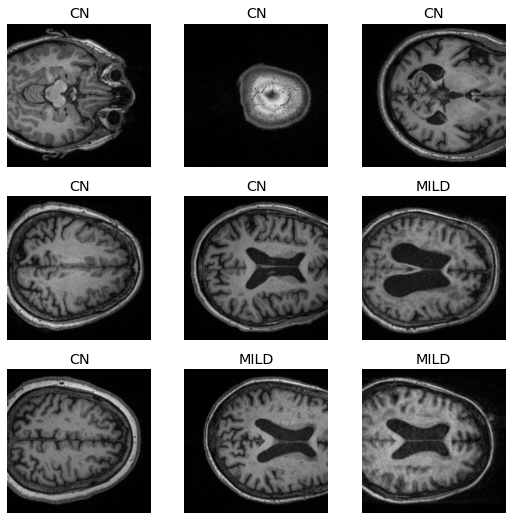

In [13]:
dls.show_batch()

In [14]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [15]:
body = create_timm_body('resnet152', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet152_a1h-dc400468.pth" to /root/.cache/torch/hub/checkpoints/resnet152_a1h-dc400468.pth


In [16]:
nf = num_features_model(nn.Sequential(*body.children())); nf

2048

In [17]:
model = nn.Sequential(body,create_head(nf=2048, n_out=2))

In [18]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.00019054606673307717)

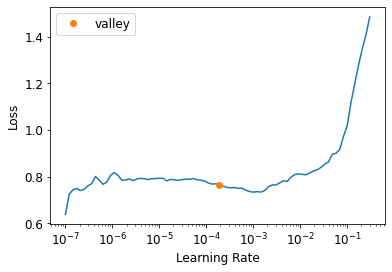

In [19]:
learn.lr_find()

In [20]:
learn.fine_tune(100,0.8e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.639125,0.508753,0.755660,03:35


epoch,train_loss,valid_loss,accuracy,time
0,0.509498,0.455699,0.784906,00:54
1,0.490873,0.432127,0.809434,00:55
2,0.455197,0.461661,0.780189,00:55
3,0.460035,0.389947,0.831132,00:55
4,0.433722,0.374224,0.836792,00:55
5,0.423051,0.372198,0.838679,00:55
6,0.388795,0.332559,0.864151,00:55
7,0.385008,0.330357,0.863208,00:55
8,0.363697,0.342410,0.848113,00:55
9,0.332226,0.328334,0.851887,00:55


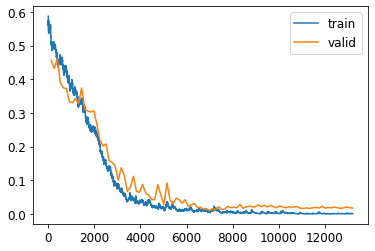

In [21]:
learn.recorder.plot_loss()

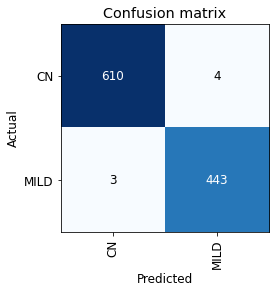

In [22]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [23]:
print("Number of examples in testing:", len(dls.valid_ds))

Number of examples in testing: 1060


In [24]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.9971697926521301

In [25]:
interp.most_confused()

[('CN', 'MILD', 4), ('MILD', 'CN', 3)]

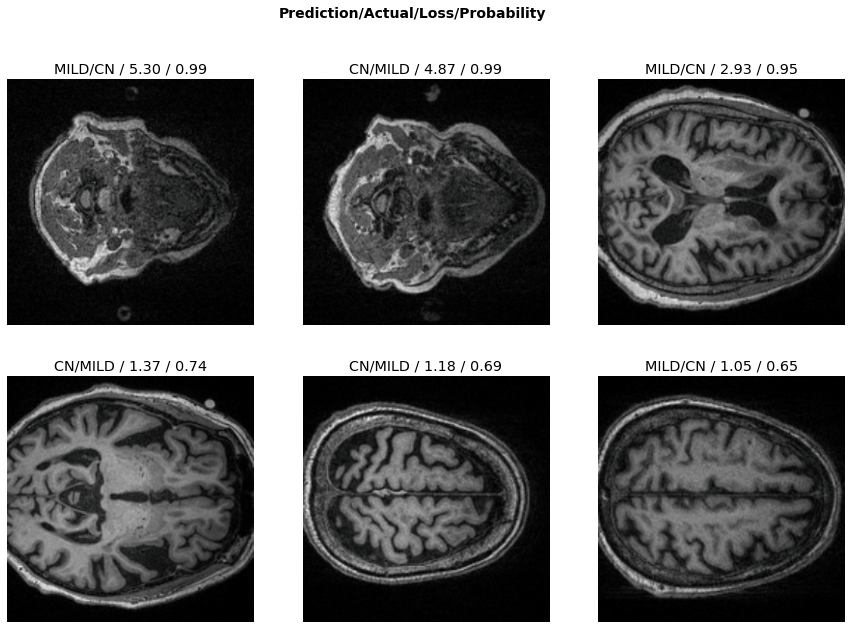

In [26]:
interp.plot_top_losses(6, figsize=(15,10))

In [27]:
interp.print_classification_report()

              precision    recall  f1-score   support

          CN       1.00      0.99      0.99       614
        MILD       0.99      0.99      0.99       446

    accuracy                           0.99      1060
   macro avg       0.99      0.99      0.99      1060
weighted avg       0.99      0.99      0.99      1060



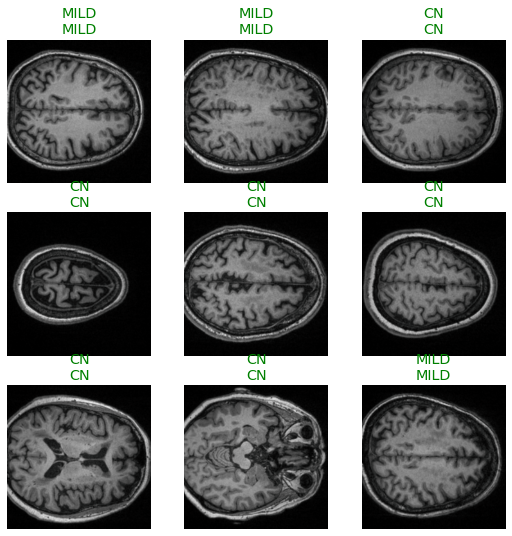

In [28]:
learn.show_results()

In [30]:
learn.save(path/'CNMILD_ResNet152_Train')

Path('/content/gdrive/MyDrive/OASIS/CNMILD_ResNet152_Train.pth')

In [31]:
learn.export(path/'Binary_ResNet152TrainExp.pkl')

In [32]:
all_files= get_image_files(path)

In [34]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='Train', valid_name='Test'),
                 get_y=parent_label,
                 item_tfms=Resize(512,method='squish'),
                 batch_tfms=Normalize.from_stats(*imagenet_stats)
                 
                 
)

In [35]:
dls_test = dblock.dataloaders(all_files)

In [36]:
print("Number of examples in testing:", len(dls_test.valid_ds))

Number of examples in testing: 650


In [38]:
learn1 = Learner(dls_test, model, metrics=accuracy).load('/content/gdrive/MyDrive/OASIS/CNMILD_ResNet152_Train,')

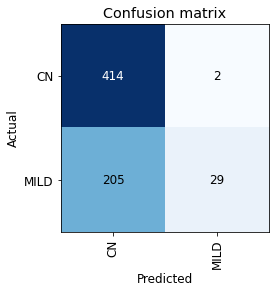

In [39]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

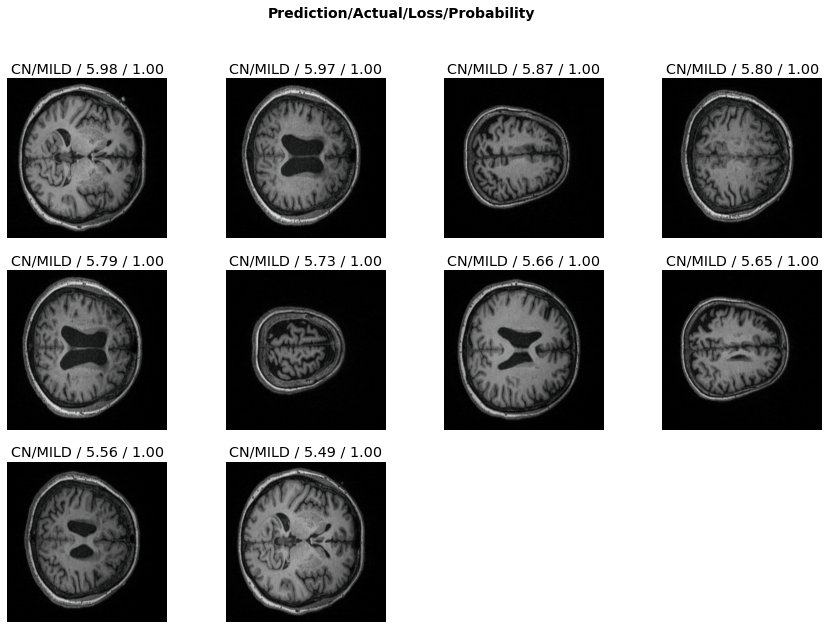

In [40]:
interp.plot_top_losses(10, figsize=(15,10))

In [41]:
interp.print_classification_report()

              precision    recall  f1-score   support

          CN       0.67      1.00      0.80       416
        MILD       0.94      0.12      0.22       234

    accuracy                           0.68       650
   macro avg       0.80      0.56      0.51       650
weighted avg       0.76      0.68      0.59       650



In [42]:
interp.most_confused()

[('MILD', 'CN', 205), ('CN', 'MILD', 2)]

In [43]:
losses,idxs = interp.top_losses(10)
print(idxs)

TensorBase([109, 138,   1,  60,  67, 213, 154, 147,  89, 176])


In [45]:
dls_test.valid_ds.items[1]

Path('/content/gdrive/MyDrive/OASIS/Test/MILD/mild_1.png')

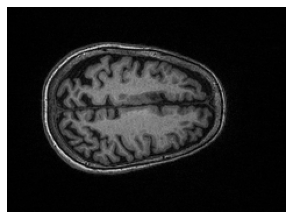

In [47]:
img = PILImage.create('/content/gdrive/MyDrive/OASIS/Test/MILD/mild_1.png')
img.show()

In [48]:
is_cancer_or_pneumonia,_,probs = learn1.predict(img)
print(f" {is_cancer_or_pneumonia}")
print(f"Probability : {probs[0].item():.2f}")

 CN
Probability : 1.00


In [49]:
learn1.predict(img)

('CN', TensorBase(0), TensorBase([0.9972, 0.0028]))

In [50]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [51]:
m = learn1.model.eval();
m;

In [52]:
target_layer = learn1.model[0][7][2]

target_layer;

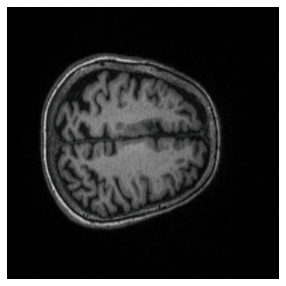

In [53]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [54]:
class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [55]:
w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()

In [56]:
def plot_gradcam(img, learn1, hooked_layer, size=512):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))

(<Figure size 1275x450 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4d2907090>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fe4d28e3350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe4d27117d0>], dtype=object),
 0.0028159535,
 0.99718404)

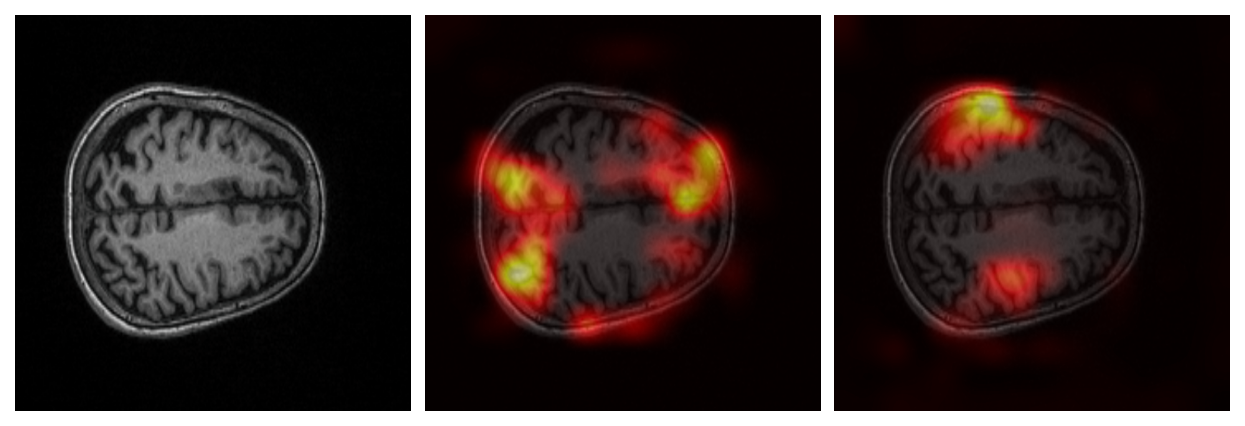

In [57]:
plot_gradcam(x_img,learn1,target_layer)

In [ ]:
#TensorBase([109, 138,   1,  60,  67, 213, 154, 147,  89, 176])

In [58]:
dls_test.valid_ds.items[109]

Path('/content/gdrive/MyDrive/OASIS/Test/MILD/mild_109.png')

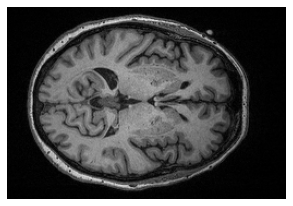

In [60]:
img = PILImage.create('/content/gdrive/MyDrive/OASIS/Test/MILD/mild_109.png')
img.show()

In [61]:
is_cancer_or_pneumonia,_,probs = learn1.predict(img)
print(f" {is_cancer_or_pneumonia}")
print(f"Probability : {probs[0].item():.2f}")

 CN
Probability : 1.00


In [62]:
learn1.predict(img)

('CN', TensorBase(0), TensorBase([0.9975, 0.0025]))

In [63]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [64]:
m = learn1.model.eval();
m;

In [65]:
target_layer = learn1.model[0][7][2]

target_layer;


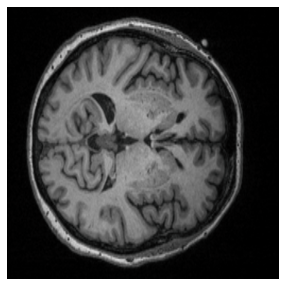

In [66]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [67]:
class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

In [68]:
w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()

In [69]:
def plot_gradcam(img, learn1, hooked_layer, size=512):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))

(<Figure size 1275x450 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4d25b6950>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fe4d287cc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe4d259bb90>], dtype=object),
 0.0025366019,
 0.9974634)

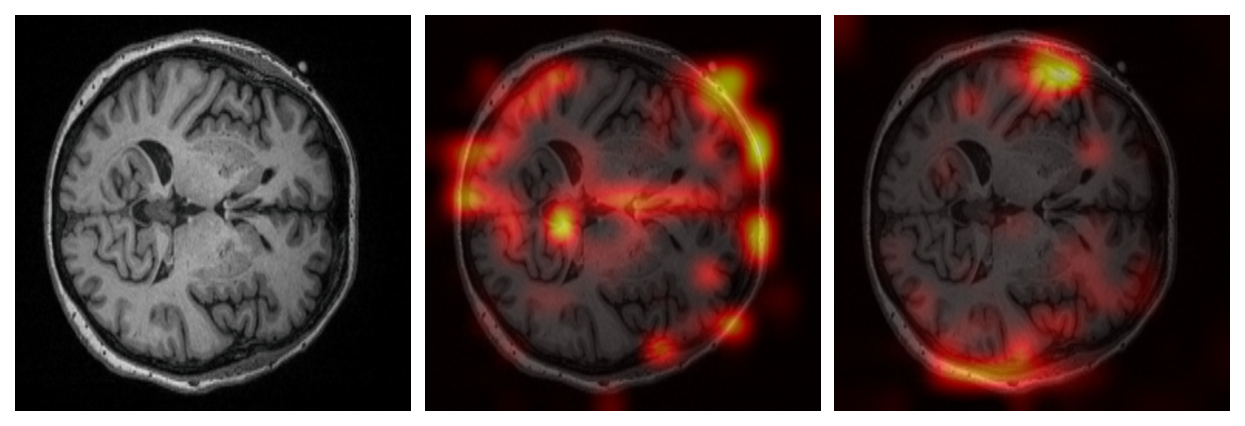

In [70]:
plot_gradcam(x_img,learn1,target_layer)